# C&C baseline

In [236]:
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pylab as plt

from fet.common import convert_times
from fet.pstats import extract_features, aggregate, swap_directions

pd.plotting.register_matplotlib_converters()
plt.style.use(['science', 'no-latex', 'bright'])

## Prepare and merge datasets

In [3]:
cnc_datasets = glob.glob(f'{base_path}/cnc/**/*.csv')

benign_datasets = [
    f'{base_path}/iottraces/16-09-23/pstats.filter.csv',
    f'{base_path}/iottraces/16-09-24/pstats.filter.csv',
    f'{base_path}/iottraces/16-09-25/pstats.filter.csv'
]

In [4]:
cnc = pd.DataFrame()
benign = pd.DataFrame()

for f in cnc_datasets:
    cnc = cnc.append(pd.read_csv(f), ignore_index=True)

for f in benign_datasets:
    benign = benign.append(pd.read_csv(f), ignore_index=True)

Convert time values.

In [5]:
cnc.rename(columns=lambda x: x.split()[1].lower(), inplace=True)

convert_times(cnc, inplace=True)
convert_times(benign, inplace=True)

Handle direction mismatch.

In [6]:
swap_directions(cnc, cnc['dst_ip'] == '10.0.42.155', inplace=True)
swap_directions(benign, benign['dst_ip'].str.startswith('192.168.'), inplace=True) 

Time aggregation.

In [7]:
cnc = aggregate(cnc)
benign = aggregate(benign)

Labels.

In [8]:
cnc['label'] = 'cnc'
benign['label'] = 'benign'

Removing flows w/ duration less then 30 seconds.

In [9]:
cnc = cnc[cnc['duration'] > 30.]
benign = benign[benign['duration'] > 30.]

In [105]:
len(benign)

5046

Imbalance.

In [106]:
len(cnc)/(len(cnc) + len(benign))

0.010588235294117647

## Explore features

In [11]:
from fet.explorer import Explorer

In [12]:
df = pd.concat([cnc, benign])

In [13]:
e = Explorer(y='label')
e.fit(df, module='pstats')

See how are features distributed between classes.

In [270]:
plt.rcParams['figure.figsize'] = [4.0, 3.0]
plt.rcParams['figure.dpi'] = 70

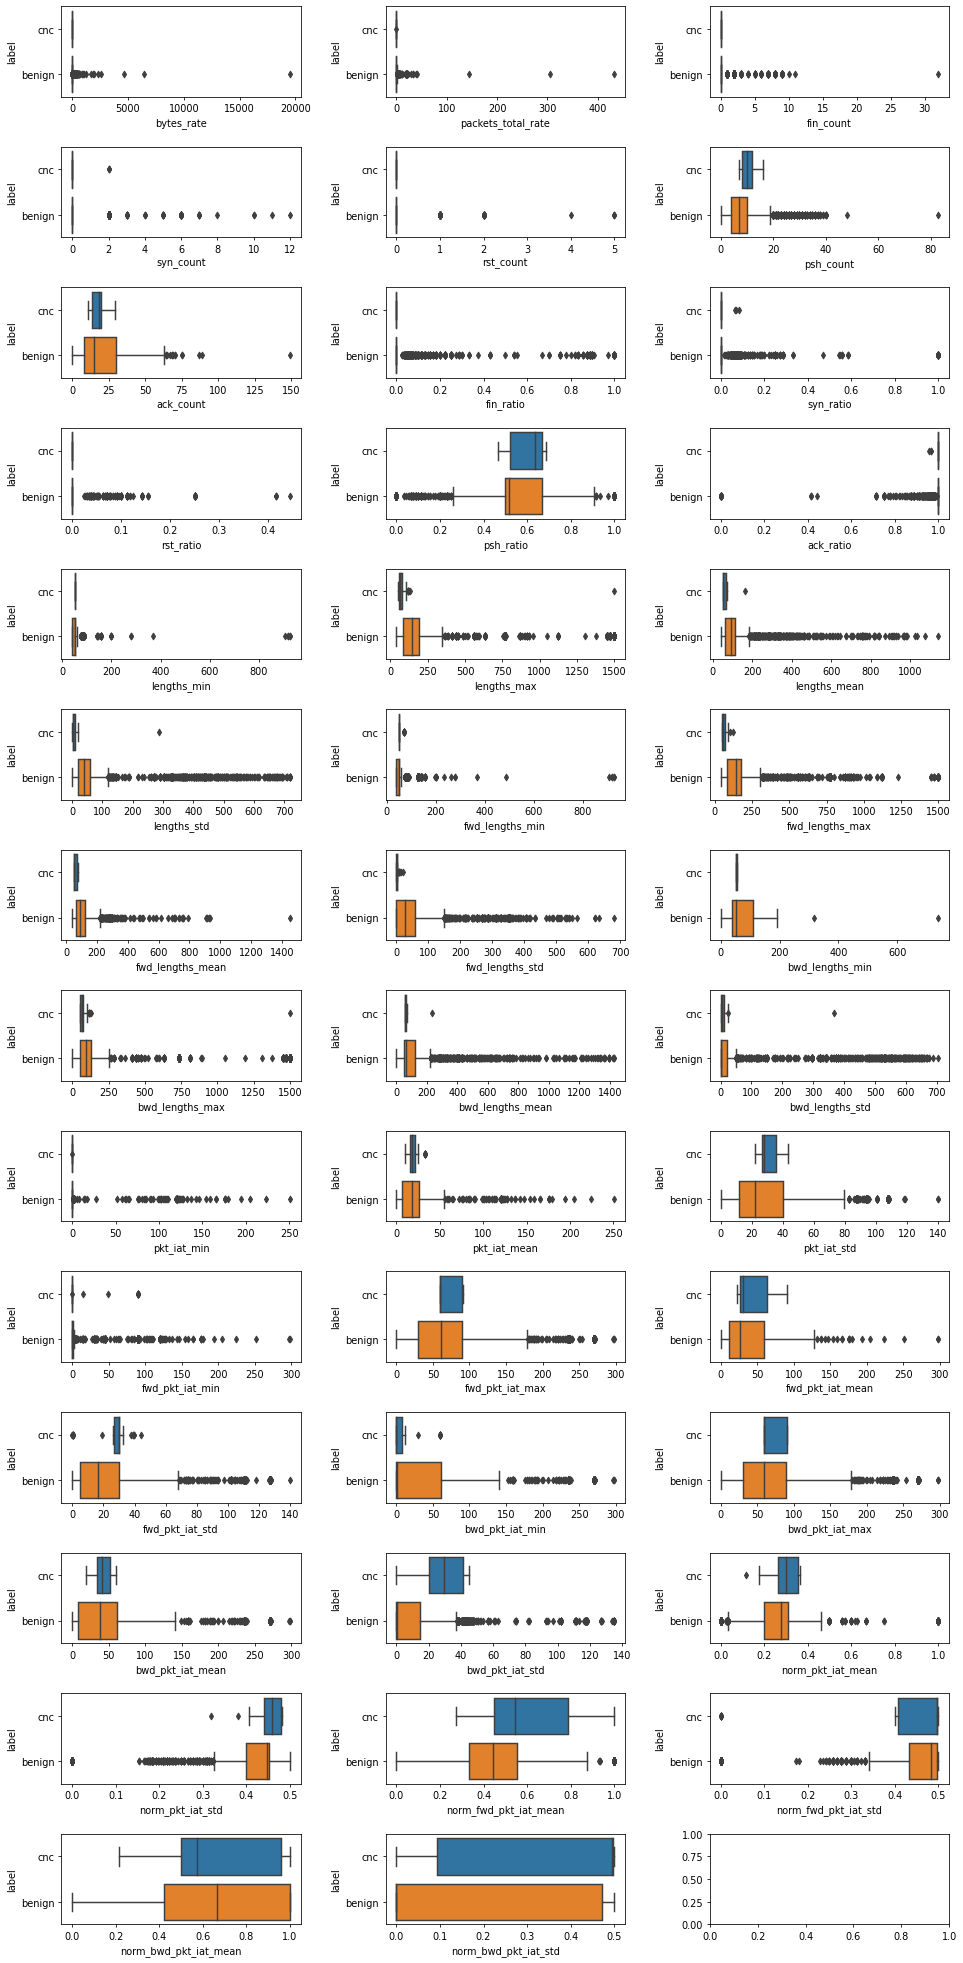

In [271]:
e.boxplot()

Feature scores based on ANOVA F-value.

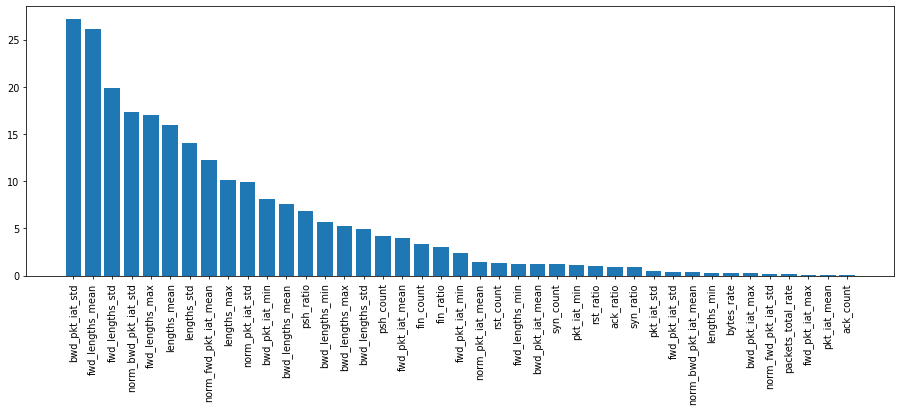

In [272]:
e.plot_feature_scores()

Feature scores based on chi-squared statistic.

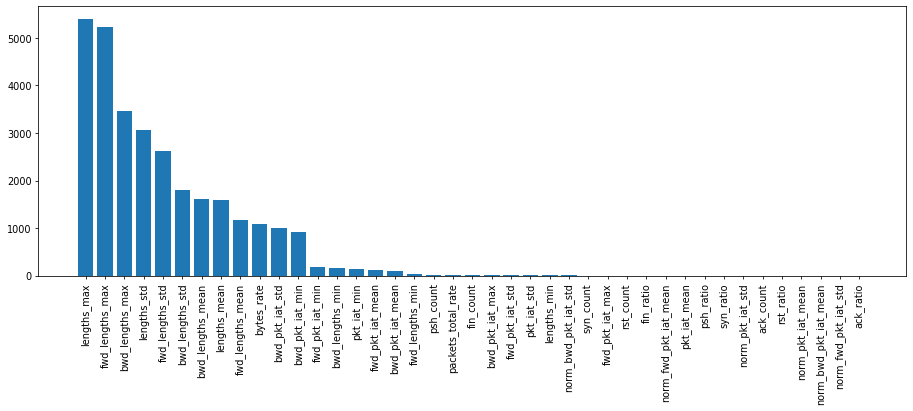

In [273]:
from sklearn.feature_selection import chi2

e.plot_feature_scores(chi2)

Feature importances for ExtraTreesClassifier.

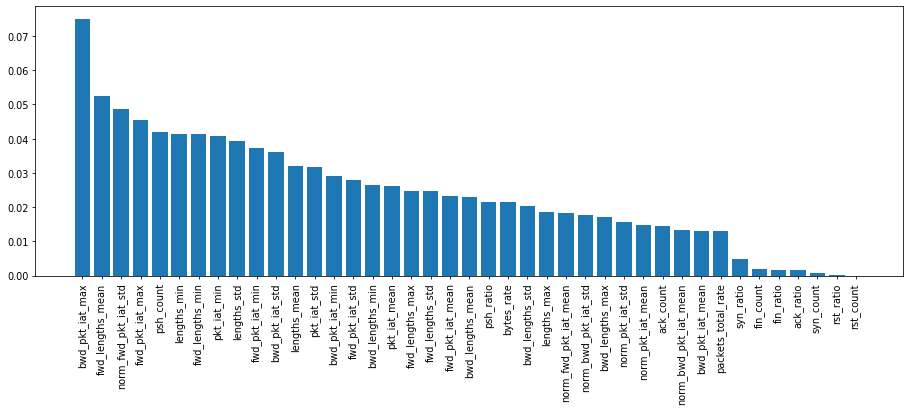

In [274]:
e.plot_feature_importances()

## Remove correlated features

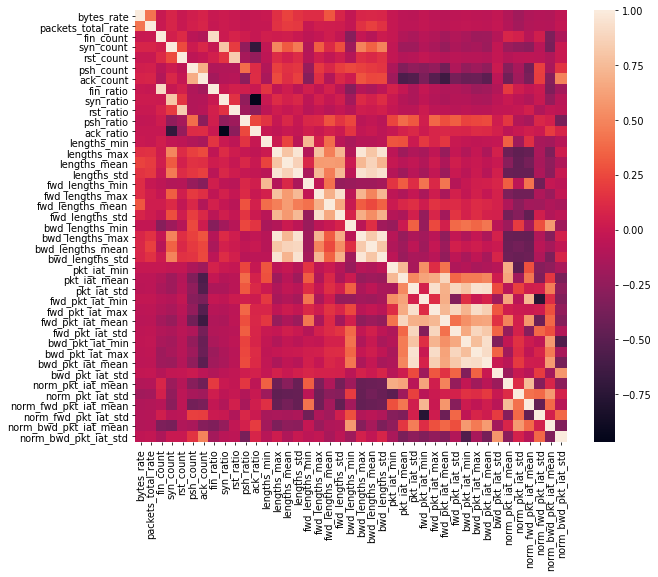

In [275]:
e.correlation_matrix()

In [276]:
e.correlated_features(threshold=0.99)

In [20]:
e.remove_features(
    [
        'bytes_rev_rate',
        'bytes_total_rate',
        'packets_rate',
        'packets_rev_rate'
    ]
)


In [22]:
e.correlated_features(threshold=0.99)

pkt_iat_max    0.999568
Name: fwd_pkt_iat_max, dtype: float64



In [23]:
e.remove_features(
    [
        'pkt_iat_max'
    ]
)

## Model preparation

In [25]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# models
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [26]:
classifiers = {
    'LogisticRegression': LogisticRegression(),
}

parameters = {
    'LogisticRegression': {
        'classifier__C' : [100, 50, 10, 1.0, 0.5, 0.1, 0.01],
        'classifier__max_iter': [10000],
    }
}

In [30]:
results = {}

In [ ]:
# Model Design and Selection with Scikit-learn - Frank Ceballos
import joblib

with joblib.parallel_backend('threading', n_jobs=8):
    
    for classifier_k, classifier_v in classifiers.items():
        print(classifier_k)
        
        steps = (('smote', SMOTE()), ('scaler', StandardScaler()), ('classifier', classifier_v))
        pipeline = Pipeline(steps=steps)
        
        param_grid = parameters[classifier_k]
        gscv = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=5)
        gscv.fit(e.df[e.feature_cols], e.df[e.y])
        
        best_params = gscv.best_params_
        best_score = gscv.best_score_
        cv_results = gscv.cv_results_
        
        tuned_params = {item[12:]: best_params[item] for item in best_params}
        classifier_v.set_params(**tuned_params)
        
        results[classifier_k] = {
            'model': pipeline,
            'cv_results': cv_results,
            'best_params': best_params,
        }
        
        with open(f'./progress/cnc-1.txt', 'w+') as f:
            f.write(f'{classifier_k}\n')

## Test on IoT-23 dataset

In [102]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, plot_confusion_matrix

def evaluate_model(cls, X, y_true, y_pred): 
    le = LabelEncoder()
    le.fit(['benign', 'cnc'])
    print(f'ROC AUC: {roc_auc_score(le.transform(y_true), le.transform(y_pred))}')
    print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
    print(f'Precision: {precision_score(y_true, y_pred, pos_label="cnc")}')
    print(f'Recall: {recall_score(y_true, y_pred, pos_label="cnc")}')
    print(f'F1 score: {f1_score(y_true, y_pred, pos_label="cnc")}')
    
    fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
    fig.tight_layout(w_pad=5)
    
    plot_confusion_matrix(cls, X, y_true, ax=axes[0], cmap=plt.cm.Blues, colorbar=False)
    plot_confusion_matrix(cls, X, y_true, ax=axes[1], cmap=plt.cm.Blues, colorbar=False, normalize='true')
    
    return fig

In [36]:
iot_23_cnc_datasets = glob.glob(f'{base_path}/iot-23/cnc/*.csv')

iot_23_benign_datasets = glob.glob(f'{base_path}/iot-23/benign/*.csv')

unsw_benign_datasets = [
    f'{base_path}/iottraces/16-09-26/pstats.filter.csv',
    f'{base_path}/iottraces/16-09-27/pstats.filter.csv',
    f'{base_path}/iottraces/16-09-28/pstats.filter.csv',
    f'{base_path}/iottraces/16-09-29/pstats.filter.csv',
    f'{base_path}/iottraces/16-09-30/pstats.filter.csv',
    f'{base_path}/iottraces/16-10-01/pstats.filter.csv',
    f'{base_path}/iottraces/16-10-02/pstats.filter.csv',
    f'{base_path}/iottraces/16-10-03/pstats.filter.csv',
    f'{base_path}/iottraces/16-10-04/pstats.filter.csv',
    f'{base_path}/iottraces/16-10-05/pstats.filter.csv',
    f'{base_path}/iottraces/16-10-06/pstats.filter.csv',
    f'{base_path}/iottraces/16-10-07/pstats.filter.csv',
]

In [37]:
def preprocess(df, swap_prefix, rename=True):
    if rename:
        df.rename(columns=lambda x: x.split()[1].lower(), inplace=True)
        
    convert_times(df, inplace=True)
    swap_directions(df, df['dst_ip'].str.startswith(swap_prefix), inplace=True)
    df = aggregate(df)
    return df

IoT-23 C&C dataset.

In [38]:
iot_23_cnc = pd.DataFrame()

for f in iot_23_cnc_datasets:
    iot_23_cnc = iot_23_cnc.append(pd.read_csv(f), ignore_index=True)
    
iot_23_cnc = preprocess(iot_23_cnc, '192.168.')

IoT-23 benign dataset.

In [39]:
iot_23_benign = pd.DataFrame()

for f in iot_23_benign_datasets:
    iot_23_benign = iot_23_benign.append(pd.read_csv(f), ignore_index=True)
    
iot_23_benign = preprocess(iot_23_benign, '192.168.')

UNSW dataset.

In [40]:
unsw_benign = pd.DataFrame()

for f in unsw_benign_datasets:
    unsw_benign = unsw_benign.append(pd.read_csv(f), ignore_index=True)

unsw_benign = preprocess(unsw_benign, '192.168.', rename=False)

Labels.

In [41]:
iot_23_cnc['label'] = 'cnc'
iot_23_benign['label'] = 'benign'
unsw_benign['label'] = 'benign'

C&C traffic destination ports.

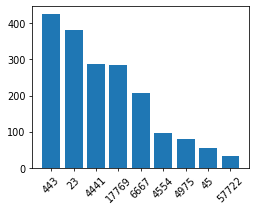

In [277]:
x = list(iot_23_cnc['dst_port'].value_counts().index)
y = list(iot_23_cnc['dst_port'].value_counts().values)

plt.bar(range(len(x)), y)
plt.xticks(range(len(x)), x, rotation=45)
plt.show()

Concat.

In [43]:
df_test = pd.concat([iot_23_cnc, iot_23_benign, unsw_benign])

Filter out short connections.

In [44]:
df_test = df_test[df_test['duration'] > 30.]

Imbalance.

In [45]:
(df_test['label'] == 'cnc').sum() / (df_test['label'] == 'benign').sum()

0.06038156428243624

In [172]:
(df_test['label'] == 'cnc').sum()

1776

In [173]:
(df_test['label'] == 'benign').sum()

30422

In [46]:
df_test = extract_features(df_test)

### Logistic Regression

ROC AUC: 0.976904364343964
Accuracy: 0.995931424312069
Precision: 0.9702687249857062
Recall: 0.9555180180180181
F1 score: 0.9628368794326241


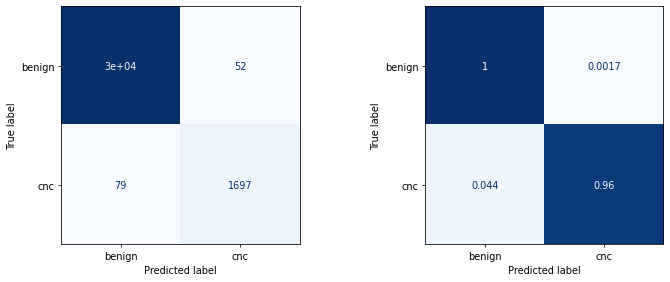

In [280]:
model = results['LogisticRegression']['model']
model.fit(e.df[e.feature_cols], e.df[e.y])
y_pred = model.predict(df_test[e.feature_cols])
_ = evaluate_model(model, df_test[e.feature_cols], df_test['label'], y_pred)

See top logistic regression features based on their coefficients (note that we standardize features as part of the pipeline).

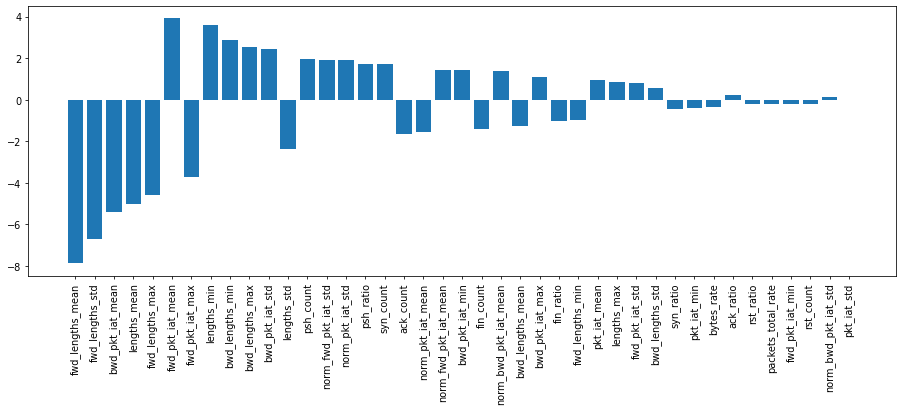

In [279]:
coefficients = []

for coef, feature in zip(model._final_estimator.coef_[0,:], e.feature_cols):
    coefficients.append((feature, coef)) 
    
coefficients = sorted(coefficients, key=lambda x: abs(x[1]), reverse=True)

n = len(coefficients)

plt.subplots(figsize=(16, 5))
plt.bar(range(n), [v for _, v in coefficients])
plt.xticks(range(n), [k for k, _ in coefficients], rotation=90)
 
plt.show()

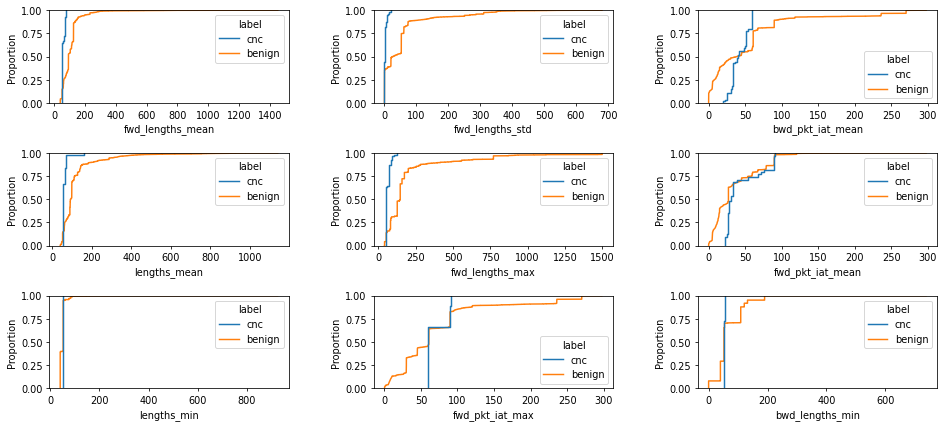

In [278]:
fig = e.ecdfplot([x[0] for x in coefficients[:9]], return_fig=True)